In [10]:
%matplotlib inline
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider
import seaborn as sns
import pandas as pd
import numpy as np
from numpy.random import randint
from copy import copy

In [61]:
class BlackJack(object):
    def __init__(self):
        self.upcard = None

        self.dealer = []
        self.player = []

        self.sum_of_dealer = 0
        self.sum_of_player = 0

        self.having_ace_flag_of_dealer = False
        self.having_ace_flag_of_player = False

        self.usable_ace_flag_of_dealer = False
        self.usable_ace_flag_of_player = False

        self.change_flag = False

        self.HIT  = 0
        self.STAY = 1
        self.action = None

        self.DEALER = -1
        self.PLAYER = 1
        self.DRAW   = 0
        self.winner = 0

        self.state_info = []
        self.end_flag = False

    def drow(self):
        card = randint(1,14)
        return card if card < 10 else 10

    def set(self):
        upcard = self.drow()
        self.upcard = upcard
        self.dealer.append(upcard)
        self.dealer.append(self.drow())
        self.player.append(self.drow())
        self.player.append(self.drow())

        self.sum_of_dealer = np.sum(self.dealer)
        self.sum_of_player = np.sum(self.player)
        self._check_have_one()

        self._judge_usable_ace(who="dealer")
        self._judge_usable_ace(who="player")

        if self.having_ace_flag_of_dealer: self.sum_of_dealer += 10
        if self.having_ace_flag_of_player: self.sum_of_player += 10


    def hit(self, who="player"):
        if who == "player":
            self.player.append(self.drow())
            self.sum_of_player = np.sum(self.player)
            self._check_have_one()
            self._judge_usable_ace(who="player")
            if self.usable_ace_flag_of_player:
                self.sum_of_player += 10
            if self.change_flag:
                self.change_flag = False
                self.sum_of_player -= 10

        elif who == "dealer":
            self.dealer.append(self.drow())
            self.sum_of_dealer = np.sum(self.dealer)
            self._check_have_one()
            self._judge_usable_ace(who="dealer")
            if self.usable_ace_flag_of_dealer:
                self.sum_of_dealer += 10
            if self.change_flag:
                self.change_flag = False
                self.sum_of_dealer -= 10

    def update(self):
        upcard = copy(self.upcard)
        sum_of_player = copy(self.sum_of_player)
        usable = copy(self.usable_ace_flag_of_player)
        action = copy(self.action)
        self.state_info.append([upcard, sum_of_player, usable, action])

    def _dealer_drowing(self):
        while True:
            if self.sum_of_dealer > self.sum_of_player:
                self.winner = self.DEALER
                self.end_flag = True
                break
            elif self.sum_of_dealer > 16:
                if self.sum_of_dealer > self.sum_of_player:
                    self.winner = self.DEALER
                    self.end_flag = True
                    break
                elif self.sum_of_dealer == self.sum_of_player:
                    self.winner = self.DRAW
                    self.end_flag = True
                    break
                else:
                    self.winner = self.PLAYER
                    self.end_flag = True
                    break
            else:
                self.hit(who="dealer")
                self._judge_bust(who="dealer")
                if self.end_flag: break

    def _check_have_one(self):
        self.having_ace_flag_of_dealer = True \
        if 1 in self.dealer else False
        self.having_ace_flag_of_player = True \
        if 1 in self.player else False

    def _judge_usable_ace(self, who):
        #check whether the player can use the ace as ten.
        if who == "dealer":
            if self.usable_ace_flag_of_dealer:
                if (1 in self.dealer) and self.sum_of_dealer < 11:
                    self.usable_ace_flag_of_dealer = True
                else:
                    self.usable_ace_flag_of_dealer = False
                    self.change_flag = True
            else:
                self.usable_ace_flag_of_dealer = True \
                if (1 in self.dealer) and self.sum_of_dealer < 11 else False

        if who == "player":
            if self.usable_ace_flag_of_player:
                if (1 in self.player) and self.sum_of_player < 11:
                    self.usable_ace_flag_of_player = True
                else:
                    self.usable_ace_flag_of_player = False
                    self.change_flag = True
            else:
                self.usable_ace_flag_of_player = True \
                if (1 in self.player) and self.sum_of_player < 12 else False

    def _judge_bust(self, who="player"):
        if who == "player":
            if self.usable_ace_flag_of_player is False \
            and self.sum_of_player > 21:
                self.winner = self.DEALER
                self.end_flag = True
        elif who == "dealer":
            if self.usable_ace_flag_of_dealer is False \
            and self.sum_of_dealer > 21:
                self.winner = self.PLAYER
                self.end_flag = True

    def play_with_policy1(self):
        '''policy1
        stay :  sum = 20, 21
        hit  :  others
        '''
        while not self.end_flag:
            if self.sum_of_player < 20:
                self.action = self.HIT
                self.update()
                self.hit(who="player")
                self._judge_bust()
            else:
                self.action = self.STAY
                self.update()
                self._dealer_drowing()

    def get_info(self):
        upcard = self.upcard
        print("upcard:", upcard)
        print("Sum of player cards:", self.sum_of_player)
        print("Sum of dealer cards:", self.sum_of_dealer)
        print("Cards of player:", self.player)
        print("Cards of dealer:", self.dealer)
        print("Winner:", self.winner)
        print("Have usable ace?:", self.usable_ace_flag_of_player)
        print("S_t-1 info:", self.state_info)

    def test(self):
        self.set()
        self.play_with_policy1()
        self.get_info()

# Episode: 10000 Times

In [64]:
#STEP 1
# Calculate value function

# shape: (usable?, upcard, sum_of_player)
V = np.zeros((2,10,10))
N = np.zeros((2,10,10))

EPISODE = 10000

for e in range(1,EPISODE+1):
    bj = BlackJack()
    bj.set()
    """policy1
    stay :  sum = 20, 21
    hit  :  others
    """
    bj.play_with_policy1()
    infos = bj.state_info
    for info in infos:
        upcard, sum_of_player, usable, _ = info[0], info[1], info[2], info[3]
        if sum_of_player < 12: continue
        #preprocess to fit shape
        upcard -= 1
        sum_of_player -= 12
        usable = int(usable)

        reward = bj.winner
        #print(usable,upcard,sum_of_player,reward)
        #print(N[usable,upcard,sum_of_player])

        N[usable,sum_of_player,upcard] += 1
        V[usable,sum_of_player,upcard] += \
        (reward - V[usable,sum_of_player,upcard])\
        /N[usable,sum_of_player,upcard]

In [67]:
x = np.arange(0, 10, 1)
y = np.arange(0, 10, 1)
X, Y = np.meshgrid(x, y)

## Having the usable ace (10000 Times)

/Users/kento_watanabe/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


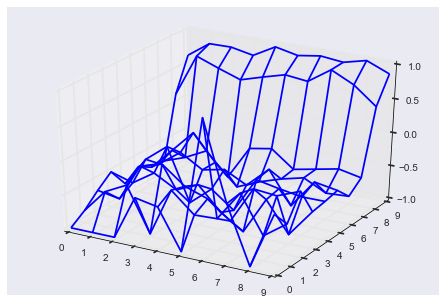

In [68]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,V[1])

## Not having the usable ace (10000 Times)

/Users/kento_watanabe/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


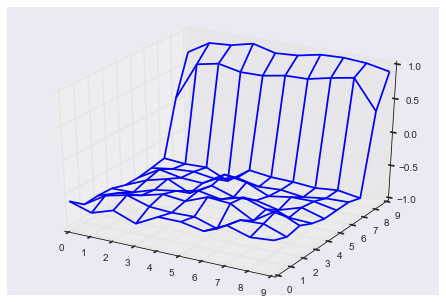

In [69]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,V[0])

# Episode: 500000 Times

In [72]:
#STEP 1
# Calculate value function

# shape: (usable?, upcard, sum_of_player)
V = np.zeros((2,10,10))
N = np.zeros((2,10,10))

EPISODE = 500000

for e in range(1,EPISODE+1):
    bj = BlackJack()
    bj.set()
    """policy1
    stay :  sum = 20, 21
    hit  :  others
    """
    bj.play_with_policy1()
    infos = bj.state_info
    for info in infos:
        upcard, sum_of_player, usable, _ = info[0], info[1], info[2], info[3]
        if sum_of_player < 12: continue
        #preprocess to fit shape
        upcard -= 1
        sum_of_player -= 12
        usable = int(usable)

        reward = bj.winner
        #print(usable,upcard,sum_of_player,reward)
        #print(N[usable,upcard,sum_of_player])

        N[usable,sum_of_player,upcard] += 1
        V[usable,sum_of_player,upcard] += \
        (reward - V[usable,sum_of_player,upcard])\
        /N[usable,sum_of_player,upcard]

/Users/kento_watanabe/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


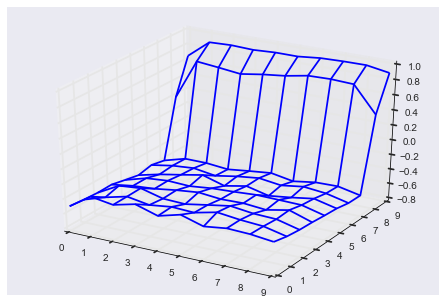

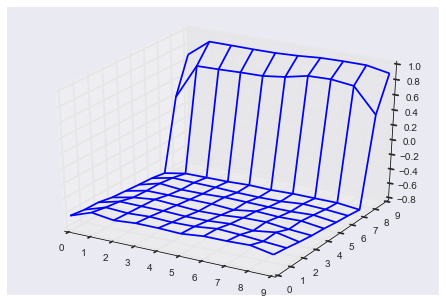

In [73]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,V[1])
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,V[0])